# Exercise 4: DCM for fMRI

## Exercise 4.1: Programming a two region DCM

### 4.1.a
Write a function to calculate the right-hand side of the differential equation (1)

In [ ]:
function single_step_neural(x::Vector{Float64}, u::Vector{Float64}, Pneural::Dict{String, Matrix{Float64}})
    u1, u2 = u[1], u[2] # u1 is driving input, u2 is modulating input of 2d input vector u (u1 and u2 are columns)
    A = Pneural["A"]    # fixed connectivity matrix
    B = Pneural["B"]    # modulatory connectivity matrix
    C = Pneural["C"]    # driving input matrix

    # defining connectivity matrix CON
    CON = zeros(2, 2)
    CON[1, 1] = -0.5 * exp(A[1, 1] + u2 * B[1, 1])
    CON[1, 2] = A[1, 2] + u2 * B[1, 2]
    CON[2, 1] = A[2, 1] + u2 * B[2, 1]
    CON[2, 2] = -0.5 * exp(A[2, 2] + u2 * B[2, 2])

    # computing dx/dt
    dx_dt = CON * x .+ C * [u1, 0.0]
    return dx_dt
end

single_step_neural (generic function with 1 method)

In [2]:
# testing 4.1a
using LinearAlgebra

A = [0.1 0.2; 0.3 0.4]

B = [0.01 0.02; 0.03 0.04]

C = [1.0 0.0; 0.0 0.0]

Pneural = Dict("A" => A, "B" => B, "C" => C)

x = [1.0, 2.0]
u = [5.0, 1.0]

dx_dt = single_step_neural(x, u, Pneural)
println("dx/dt = ", dx_dt)

dx/dt = [4.881860964770564, -1.222707218511336]


### 4.1.b
Write a function that computes the update for the hemodynamic model of a single region

In [ ]:
function single_step_hrf(h::Vector{Float64}, x::Float64, PHRF::Dict{String, Float64})
    s, f, v, q = h

    # note: fixed values in exercise: κ = 0.64, γ = 0.32, τ = 2, α = 0.32 and E0 = 0.4
    k = PHRF["k"]
    y = PHRF["y"]
    t = PHRF["t"]
    a = PHRF["a"]
    E0 = PHRF["E0"]

    # println("k = ", k)
    # println("y = ", y)
    # println("t = ", t)
    # println("a = ", a)
    # println("E0 = ", E0)

    # getting ds (eq. 4)
    ds = x - k * s - y * (f - 1)
    # getting df (eq. 5)
    df = s
    # getting dv (eq. 6)
    dv = (1 / t) * (f - v^(1 / a))
    # getting dv (eq. 6)
    interm = (1 - (1 - E0)^(1 / f)) / E0
    dq = (1/t) * (f * interm - v^(1 / a) * (q / v))

    return [ds, df, dv, dq]
end


single_step_hrf (generic function with 1 method)

### 4.1.c
Write a function to which uses v and q (rows 3 and 4 in h) to compute the BOLD signal change y (using slide 24)

In [4]:
function compute_bold_signal(h::Vector{Float64}, PHRF::Dict{String, Float64})
    v = h[3]
    q = h[4]

    # Fixed constants for 3 Tesla
    V0 = 0.04
    E0 = PHRF["E0"]
    e = 0.47
    r0 = 110.0
    theta0 = 80.6
    TE = 0.035

    # equations from slide 24
    k1 = 4.3 * theta0 * E0 * TE
    k2 = e * r0 * E0 * TE
    k3 = 1 - e

    # BOLD signal equation, also from slide 24
    y = V0 * (k1 * (1 - q) + k2 * (1 - (q / v)) + k3 * (1 - v))
    return y
end


compute_bold_signal (generic function with 1 method)

### 4.1.d
Write a function which emulates a simple Euler integrator and iterates over all time steps of the input to generate the neural (x), hemodynamic (h) and BOLD (y) traces. 

In [ ]:
function euler_integrate_dcm(U::Dict, Pneural::Dict, PHRF::Dict, x0::Vector{Float64}, h0::Matrix{Float64})
    dt = U["dt"]
    u_matrix = U["u"]
    T = size(u_matrix, 2)

    n_regions = length(x0)  # should be 2
    n_states = size(h0, 1)  # s, f, v, q states for hemodynamics

    x_trace = zeros(n_regions, T)   # neural activity over time of n regions? 
    h_trace = zeros(n_states, n_regions, T)    # hemodynamic states over time of n regions? (look at 4.1b)
    y_trace = zeros(n_regions, T)   # BOLD signal traces of n regions

    # Initial states
    x = copy(x0)
    h = copy(h0)

    # euler integration loops: x+1 = x + dt * (dx/dt)
    for t in 1:T
        u = u_matrix[:, t]

        # updating neural activity
        dxdt = single_step_neural(x, u, Pneural)
        x += dt * dxdt
        x_trace[:, t] = x

        # updating hemodynamics (balloon model slide 23)
        for r in 1:n_regions
            # originally just:

            # dhdt = single_step_hrf(h[:, r], x[r], PHRF)
            # h[:, r] += dt * dhdt
            # h_trace[:, r, t] = h[:, r]

            # however, this lead to invalid values in single_step_hrf when running the optimiser of 4.3. 
            # A simple (though hacky) solution is to just clamp values to a valid range

            dhdt = single_step_hrf(h[:, r], x[r], PHRF)
            h[:, r] .+= dt .* dhdt

            # Clamp flow & volume to avoid negative or zero
            # h = [s, f, v, q]
            f_idx = 2
            v_idx = 3
            h[f_idx, r] = max(h[f_idx, r], 1e-8)
            h[v_idx, r] = max(h[v_idx, r], 1e-8)

            h_trace[:, r, t] .= h[:, r]
        end
    end

    # computing BOLD signal after simulation
    for t in 1:T
        for r in 1:n_regions
            y_trace[r, t] = compute_bold_signal(h_trace[:, r, t], PHRF)
        end
    end

    return y_trace, h_trace, x_trace
end


euler_integrate_dcm (generic function with 1 method)

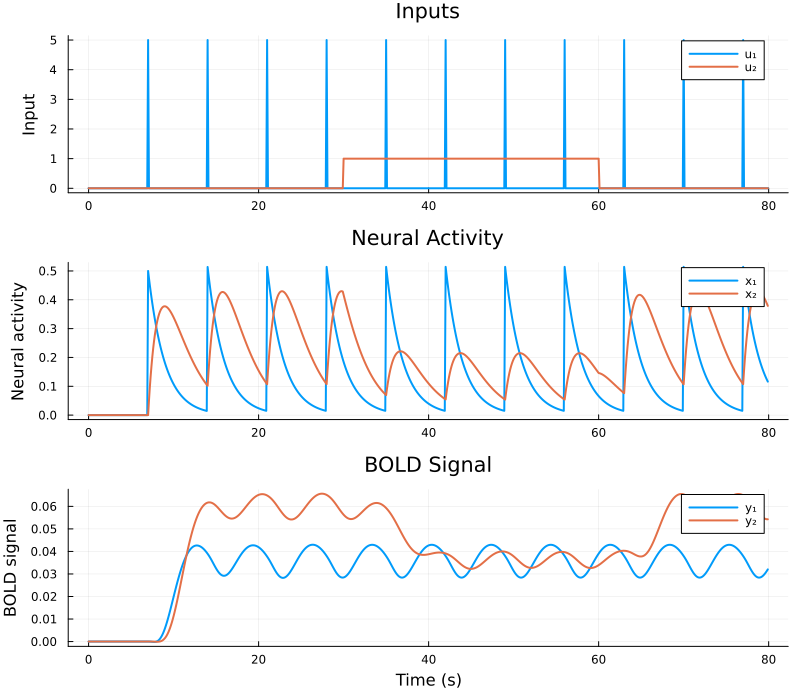

In [6]:
dt = 0.1
T = 80.0
time_steps = Int(T / dt)
time = collect(0:dt:(T - dt))

# u1 is driving input of 5 every 7 seconds
u1 = zeros(time_steps)
for t in 2:time_steps
    if mod(time[t], 7.0) == 0.0
        
        u1[t] = 5.0
    end
end
# u2 is modulating input (1 for 30-60 seconds, 0 otherwise)
u2 = [((30.0 <= t <= 60.0) ? 1.0 : 0.0) for t in time]

U = Dict("u" => hcat(u1, u2)', "dt" => dt) # putting u1 and u2 into a matrix, then transposing so its 2 × 800

# parameters (from assignment)
A = [0.0 0.0; 1.0 0.0]
B = [0.0 0.0; -0.5 0.0]
C = [1.0 0.0; 0.0 0.0]
Pneural = Dict(
    "A" => A, 
    "B" => B, 
    "C" => C)

# hemodynamic parameters from 1.4b
PHRF = Dict(
    "k" => 0.64, 
    "y" => 0.32, 
    "t" => 2.0, 
    "a" => 0.32, 
    "E0" => 0.4)

x0 = [0.0, 0.0]
h0 = [0.0 0.0; 1.0 1.0; 1.0 1.0; 1.0 1.0]  # 4 hemodynamic states for 2 regions
y, h, x = euler_integrate_dcm(U, Pneural, PHRF, x0, h0)

# Plotting
using Plots

# Create time vector
time = collect(0:U["dt"]:(size(U["u"], 2) - 1) * U["dt"])

# transposing matrices for plotting
u_plot = U["u"]'
x_plot = x'
y_plot = y'

plot(layout = (3, 1), size=(800, 700), legend = :topright)

# input (u1 and u2)
plot!(time, u_plot[:, 1], label="u₁", lw=2, subplot=1)
plot!(time, u_plot[:, 2], label="u₂", lw=2, subplot=1)
ylabel!("Input", subplot=1)
title!("Inputs", subplot=1)

# neural activity (x1 and x2)
plot!(time, x_plot[:, 1], label="x₁", lw=2, subplot=2)
plot!(time, x_plot[:, 2], label="x₂", lw=2, subplot=2)
ylabel!("Neural activity", subplot=2)
title!("Neural Activity", subplot=2)

# BOLD signal (y1 and y2)
plot!(time, y_plot[:, 1], label="y₁", lw=2, subplot=3)
plot!(time, y_plot[:, 2], label="y₂", lw=2, subplot=3)
ylabel!("BOLD signal", subplot=3)
xlabel!("Time (s)", subplot=3)
title!("BOLD Signal", subplot=3)


## Exercise 4.2: Exploring the effect of modulation

### 4.2.a
Run the simulation without modulation

In [7]:
# Helper function to update B matrix
function run_model_with_B(B::Matrix{Float64})
    Pneural_mod = Dict(
        "A" => A,
        "B" => B,
        "C" => C
    )
    return euler_integrate_dcm(U, Pneural_mod, PHRF, x0, h0)
end

B1 = zeros(2, 2)
y_B1, _, x_B1 = run_model_with_B(B1)

([0.0 0.0 … 0.03143203048216777 0.032029227494748444; 0.0 0.0 … 0.054362695630247995 0.054352977516206415], [0.0 0.0; 1.0 1.0; 1.0 1.0; 1.0 1.0;;; 0.0 0.0; 1.0 1.0; 1.0 1.0; 1.0 1.0;;; 0.0 0.0; 1.0 1.0; 1.0 1.0; 1.0 1.0;;; … ;;; 0.09587126616026394 0.17200254883608024; 1.587676719045863 1.8313483404195656; 1.1424706834354366 1.2003341563929786; 0.8620082761947023 0.7532542485999383;;; 0.08315850583304812 0.1729895480103026; 1.5972638456618893 1.8485485953031737; 1.1460428899386421 1.2034329502868804; 0.8594069388656104 0.7534580317550783;;; 0.07034114132923586 0.17265592119309228; 1.605579696245194 1.865847550104204; 1.1493512292688226 1.2066760741104463; 0.8566485697796079 0.7534107174411274], [0.0 0.0 … 0.12228655716508703 0.11617222930683269; 0.0 0.0 … 0.38598309193157604 0.37891259305150593])

### 4.2.b
Explore the changes in the activity $x$ and the BOLD signal $y$ of region 2 when $b$ value is changed

In [8]:
b_values = [-1.0, -0.5, 0.0, 0.5, 1.0]
results_B2 = Dict()
results_B3 = Dict()

for b in b_values
    # B2: modulation on connection from region 1 to 2
    B2 = [0.0 0.0; b 0.0]
    y, h, x = run_model_with_B(B2)
    results_B2[b] = (y, x)

    # B3: self-modulation of region 2
    B3 = [0.0 0.0; 0.0 b]
    y, h, x = run_model_with_B(B3)
    results_B3[b] = (y, x)
end

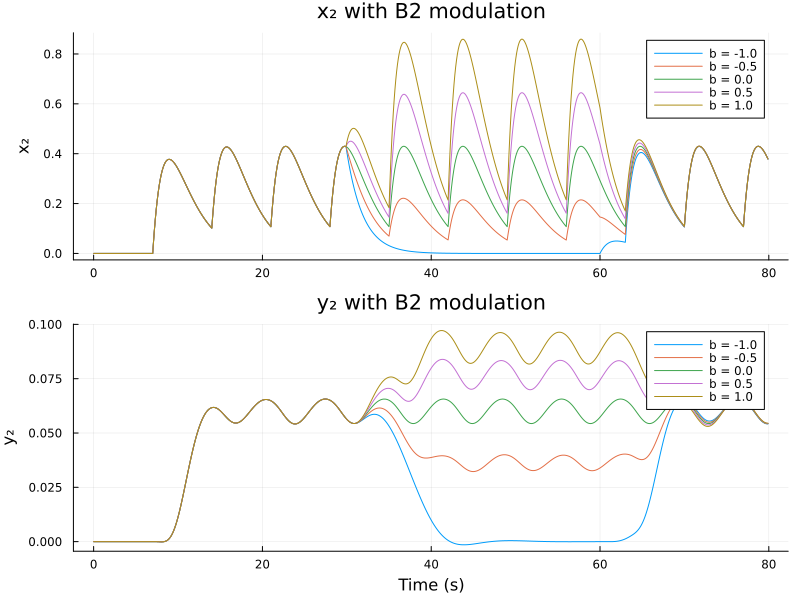

In [9]:
# Plot neural activity x2 for B2
plot(layout=(2, 1), size=(800, 600), legend=:topright)
for b in b_values
    x2 = results_B2[b][2][2, :]  # x2 over time
    plot!(time, x2, label="b = $b", subplot=1)
end
title!("x₂ with B2 modulation", subplot=1)
ylabel!("x₂", subplot=1)

# BOLD signal y2 for B2
for b in b_values
    y2 = results_B2[b][1][2, :]
    plot!(time, y2, label="b = $b", subplot=2)
end
title!("y₂ with B2 modulation", subplot=2)
ylabel!("y₂", subplot=2)
xlabel!("Time (s)", subplot=2)

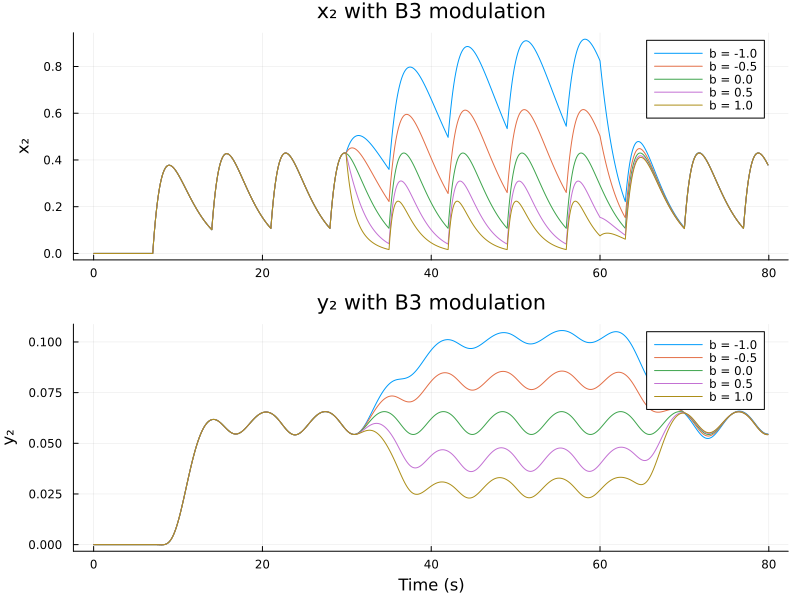

In [10]:
# Plot neural activity x2 for B3
plot(layout=(2, 1), size=(800, 600), legend=:topright)
for b in b_values
    x2 = results_B3[b][2][2, :]
    plot!(time, x2, label="b = $b", subplot=1)
end
title!("x₂ with B3 modulation", subplot=1)
ylabel!("x₂", subplot=1)

# BOLD signal y2 for B3
for b in b_values
    y2 = results_B3[b][1][2, :]
    plot!(time, y2, label="b = $b", subplot=2)
end
title!("y₂ with B3 modulation", subplot=2)
ylabel!("y₂", subplot=2)
xlabel!("Time (s)", subplot=2)

**Observations**:
- Changes in $b$ value are more visible in $B_2$ as they are altering intra-network connectivity
- For $B3$, we're modulating region 2 own self-inhibition, so changes in persistence and decay rate of $x_2$ can be observed
- When $b > 0$, effective connectivity increases, and when $b < 0$, it becomes more inhibitory

## Exercise 4.3: Maximum likelihood and maximum a posteriori (MAP) estimates

### 4.3.a
Noisy BOLD trace $\hat{y} = y + \epsilon$ from model 2

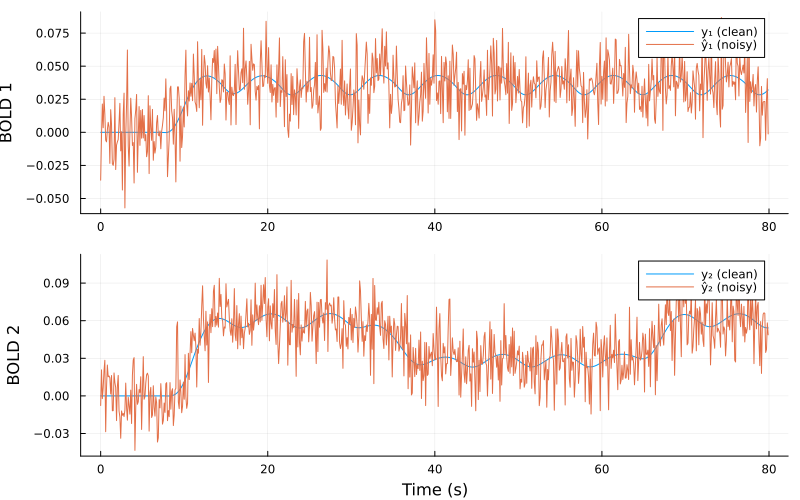

In [11]:
using Statistics, Random

function add_noise_to_bold(y::Matrix{Float64})
    sigma_y = std(vcat(y...))  # Flatten y into a vector to compute global std
    eps = sigma_y .* randn(size(y))  # Gaussian noise of the same shape as y
    y_noisy = y + eps
    return y_noisy, sigma_y
end

# Generate noisy BOLD trace
y_noisy, sigma_y = add_noise_to_bold(y)

plot(layout=(2, 1), size=(800, 500), legend=:topright)
plot!(time, y[1, :], label="y₁ (clean)", subplot=1)
plot!(time, y_noisy[1, :], label="ŷ₁ (noisy)", subplot=1)
ylabel!("BOLD 1", subplot=1)
plot!(time, y[2, :], label="y₂ (clean)", subplot=2)
plot!(time, y_noisy[2, :], label="ŷ₂ (noisy)", subplot=2)
ylabel!("BOLD 2", subplot=2)
xlabel!("Time (s)", subplot=2)

### 4.3.b
Compute log-likelihood L of the model for a given set of connectivity parameters

In [12]:
# Helper: Convert π vector into A, B, C matrices
function unpack_parameters(π::Vector{Float64})
    A = [π[1] 0.0;
         π[2] π[3]]
    B = [0.0 0.0;
         π[4] 0.0]
    C = [π[5] 0.0;
         0.0 0.0]
    return A, B, C
end

# Log-likelihood function
function log_likelihood(π_params::Vector{Float64}, y_obs::Matrix{Float64}, σϵ::Float64)
    # Unpack parameters
    A, B, C = unpack_parameters(π_params)
    Pneural = Dict("A" => A, "B" => B, "C" => C)

    # Simulate BOLD signal using current parameters
    y_sim, _, _ = euler_integrate_dcm(U, Pneural, PHRF, x0, h0)

    # Gaussian log-likelihood
    diff = y_obs .- y_sim
    N = length(diff)
    return -0.5 * N * log(2 * pi * σϵ^2) - sum(diff.^2) / (2 * σϵ^2)
end

log_likelihood (generic function with 1 method)

In [13]:
# Log joint distribution function (log-likelihood + log-prior)
function log_joint(π_params::Vector{Float64}, y_obs::Matrix{Float64}, σϵ::Float64, σ_prior::Float64)
    # Compute log-likelihood
    ll = log_likelihood(π_params, y_obs, σϵ)

    # Gaussian prior parameters (mean = 0, variance = σ_prior^2)
    prior_mean = 0.0
    prior_variance = σ_prior^2

    # Compute log-prior (Gaussian prior)
    # π has length 5 as defined: [a11, a21, a22, b21, c11]
    D = length(π_params)
    log_prior = -0.5 * D * log(2 * pi * prior_variance) - sum((π_params .- prior_mean).^2) / (2 * prior_variance)

    # Log joint distribution
    return ll + log_prior
end

log_joint (generic function with 1 method)

### 4.3 c: Comparing maximum likelihood and MAP estimates

In [14]:
using Optim

# 1) Define “negative” cost functions 

# Negative log-likelihood
function neg_log_likelihood(π_params::Vector{Float64})
    return -log_likelihood(π_params, y_noisy, sigma_y)
end

# Negative log-joint (likelihood + prior)
function neg_log_joint(π_params::Vector{Float64}, σ_prior::Float64)
    return -log_joint(π_params, y_noisy, sigma_y, σ_prior)
end

# 2) ML: No prior term 
π_init = [0.1, 0.2, 0.1, -0.5, 1.0]  # starting guess

# Optimize negative log-likelihood => ML estimate
res_ml = optimize(π -> neg_log_likelihood(π),
                  π_init,
                  LBFGS()) 
π_ml = Optim.minimizer(res_ml)
L_ml = -Optim.minimum(res_ml)  # log-likelihood at the optimum

println("==== ML Estimate ====")
println("π_ml       = ", π_ml)
println("logLike(ML) = ", L_ml)


# 3) MAP: Vary the prior variance σ² 

sigma2_list = [10.0, 0.1, 1e-3, 1e-5]


map_results  = Vector{Vector{Float64}}()
map_loglikes = Float64[]

for sigma2 in sigma2_list
    σ_prior = sqrt(sigma2)
    
    # Optimize negative log-joint => MAP estimate
    cost_fun = p -> neg_log_joint(p, σ_prior)
    res_map  = optimize(cost_fun, π_init, LBFGS())
    π_map    = Optim.minimizer(res_map)
    
    # Compute log-likelihood at the MAP estimate
    L_map    = log_likelihood(π_map, y_noisy, sigma_y)
    
    push!(map_results, π_map)
    push!(map_loglikes, L_map)
    
    println("==== MAP Estimate with σ² = $sigma2 ====")
    println("π_map        = ", π_map)
    println("logLike(MAP) = ", L_map)
end

# 4) Compare ML vs MAP solutions

println("\nComparison:")
println("ML  parameters: ", π_ml)
println("ML  logLike:    ", L_ml)
for (i, sigma2) in enumerate(sigma2_list)
    println("MAP (σ²=$sigma2) parameters: ", map_results[i])
    println("MAP (σ²=$sigma2) logLike:    ", map_loglikes[i])
end


==== ML Estimate ====
π_ml       = [-0.09100891394834437, 1.426007191628046, 0.3941395439662706, -0.8912295559393351, 0.9233533920452509]
logLike(ML) = 4199.526728756169
==== MAP Estimate with σ² = 10.0 ====
π_map        = [-0.08894758653157683, 1.416036715891714, 0.38711980595507134, -0.8850391144429149, 0.9252700802483668]
logLike(MAP) = 4199.525698288004
==== MAP Estimate with σ² = 0.1 ====
π_map        = [-0.04684434026676941, 1.085025153103384, 0.12101777841017824, -0.6795493839083792, 0.9667080334871825]
logLike(MAP) = 4197.4783531490875
==== MAP Estimate with σ² = 0.001 ====
π_map        = [-0.36116395121487244, 0.576045733743891, -0.2956581801441412, -0.2531430296087262, 0.6852975517561363]
logLike(MAP) = 4079.9028877507667
==== MAP Estimate with σ² = 1.0e-5 ====
π_map        = [-0.0012875917862794166, 0.0033857789887652917, -1.2047774690973299e-5, 0.0009981447504921212, 0.036652225574261184]
logLike(MAP) = 165.371539679124

Comparison:
ML  parameters: [-0.09100891394834437, 1.

#### Discussion
##### Does a Tighter Prior Always Lead to More Shrinkage?

Overall, yes. When the prior variance is reduced(e.g. $\sigma^2 = 10 \to 10^{-5}$), the prior becomes stronger in “pulling” the parameters toward zero (the prior mean). Looking at the estimates:
- For $\sigma^2 = 10$, the MAP estimate is quite close to the ML estimate.
- As $\sigma^2$ shrinks to 0.1, 0.001, and especially $10^{-5}$, more parameters are driven much closer to zero.

However, it does not always reduce each parameter’s absolute magnitude monotonically. For example, $a_{11}$ goes from about -0.09 at ML to -0.36 when $\sigma^2 = 10^{-3}$, which is a larger (more negative) value. Maybe this happens due to correlations among parameters in the likelihood – i.e. shifting one parameter helps compensate for others? But the overall tendency is smaller variance → more shrinkage toward zero.

##### Log-Likelihood at the MAP vs. ML
- The ML solution aims only to maximize the likelihood, so it tends to achieve the highest log-likelihood ($\approx 4199.53$ in the results).
- The MAP solutions must balance between fitting the data and satisfying the prior constraint. So as $\sigma^2$ gets smaller, the log-likelihood at the MAP estimate decreases (e.g. dropping to 165.37 by $\sigma^2=10^{-5}$) because the prior forces the parameters closer to zero than the data alone would choose.

In short, the MAP estimates for weak priors ($\sigma^2=10$) end up very close to ML with nearly the same log-likelihood, but for tight priors ($\sigma^2=10^{-5}$), the log-likelihood is sacrificed heavily in favor of “shrinkage” toward zero.